### **Portfolio Optmization using Modern Portfolio Theory & CAPM**
This project applies CAPM and Modern Portfolio Theory to build an optimized portfolio of top financial stocks namely-Barclays,Citi,American Express,Wells Fargo,JPMC and Morgan Stanley. It estimates expected returns using CAPM, constructs the efficient frontier, and identifies the maximum Sharpe ratio and minimum volatility portfolios. Portfolio risk is evaluated using VaR, CVaR, skewness, and kurtosis, and results are presented through clear visualizations of the risk–return tradeoff and asset allocation.

Importing Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import datetime
from scipy.interpolate import interp1d
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")
import requests
import time

Data Collection

In [2]:
# FIX 1: Use headers to avoid 403 Forbidden
headers = {"User-Agent": "Mozilla/5.0"}
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url, headers=headers)
tickers = pd.read_html(response.text)[0]['Symbol'].tolist()

# FIX 3: Replace dots with dashes
tickers = [t.replace('.', '-') for t in tickers]

all_data = []

# FIX 4: Batching to avoid Rate Limits
for i in range(0, len(tickers), 50):
    batch = tickers[i:i+50]
    # FIX 2: group_by='ticker' to handle Multi-Index correctly
    data = yf.download(batch, period="5y", group_by='ticker', actions=True)

    for ticker in batch:
        try:
            if ticker in data.columns.levels[0]:
                df = data[ticker].dropna(how='all').copy()
                df['Company'] = ticker
                all_data.append(df.reset_index())
        except Exception:
            continue

    print(f"Finished batch {i//50 + 1}")
    time.sleep(2) # Be kind to the server

final_df = pd.concat(all_data)
final_df.to_csv("sp500_clean.csv", index=False)

[*********************100%***********************]  50 of 50 completed


Finished batch 1


[*********************100%***********************]  50 of 50 completed


Finished batch 2


[*********************100%***********************]  50 of 50 completed


Finished batch 3


[*********************100%***********************]  50 of 50 completed


Finished batch 4


[*********************100%***********************]  50 of 50 completed


Finished batch 5


[*********************100%***********************]  50 of 50 completed


Finished batch 6


[*********************100%***********************]  50 of 50 completed


Finished batch 7


[*********************100%***********************]  50 of 50 completed


Finished batch 8


[*********************100%***********************]  50 of 50 completed


Finished batch 9


[*********************100%***********************]  50 of 50 completed


Finished batch 10


[*********************100%***********************]  3 of 3 completed


Finished batch 11


Data Cleaning

In [3]:
df=pd.read_csv("sp500_clean.csv")
df1=df.pivot(index="Date",columns="Company",values="Close")

# lets go with the Financial stocks
tickers=["BAC","AXP","C","WFC","JPM","MS"]
start_date = "2021-01-14"
end_date = "2026-01-09"

# Now i will make a function to create a dataframe from my available df1 to get the data of my selected
# stocks for the portfolio from the start date to the end date that i fix
# will pass on a ticker array of selected stocks
def selected_stocks(tickers,start_date,end_date):
 df_portfolio=df1[tickers]
 df_portfolio=df_portfolio.loc[start_date:end_date]
 return df_portfolio

df_portfolio=selected_stocks(tickers,start_date,end_date)

In [4]:
df_portfolio

Company,BAC,AXP,C,WFC,JPM,MS
Date,,,,,,
2021-01-14,30.123138,116.513954,57.724819,30.970385,124.318047,65.191826
2021-01-15,29.254631,114.979645,53.726486,28.555141,122.090080,64.143219
2021-01-19,29.041941,119.309593,53.274788,29.080973,121.561684,63.930099
2021-01-20,28.660856,121.371048,52.906746,28.929457,119.738800,63.802216
2021-01-21,28.155699,119.949715,51.752415,28.519489,118.734909,63.682861
...,...,...,...,...,...,...
2026-01-05,56.889999,379.799988,123.300003,96.379997,332.540009,186.539993
2026-01-06,57.250000,383.559998,122.500000,96.389999,334.609985,187.750000
2026-01-07,55.639999,378.220001,121.370003,94.290001,326.989990,184.789993


Data distribution-To visualize the close price hsitogram of selected stocks

Returns Calculation

In [5]:
df_returns=df_portfolio.pct_change().dropna()
df_returns

Company,BAC,AXP,C,WFC,JPM,MS
Date,,,,,,
2021-01-15,-0.028832,-0.013168,-0.069265,-0.077986,-0.017922,-0.016085
2021-01-19,-0.007270,0.037658,-0.008407,0.018415,-0.004328,-0.003323
2021-01-20,-0.013122,0.017278,-0.006908,-0.005210,-0.014996,-0.002000
2021-01-21,-0.017625,-0.011711,-0.021818,-0.014171,-0.008384,-0.001871
2021-01-22,-0.006925,-0.010123,-0.008728,-0.003125,-0.007714,-0.007630
...,...,...,...,...,...,...
2026-01-05,0.016801,0.018968,0.038753,0.012395,0.026300,0.025509
2026-01-06,0.006328,0.009900,-0.006488,0.000104,0.006225,0.006487
2026-01-07,-0.028122,-0.013922,-0.009224,-0.021786,-0.022773,-0.015766


Data Visualization

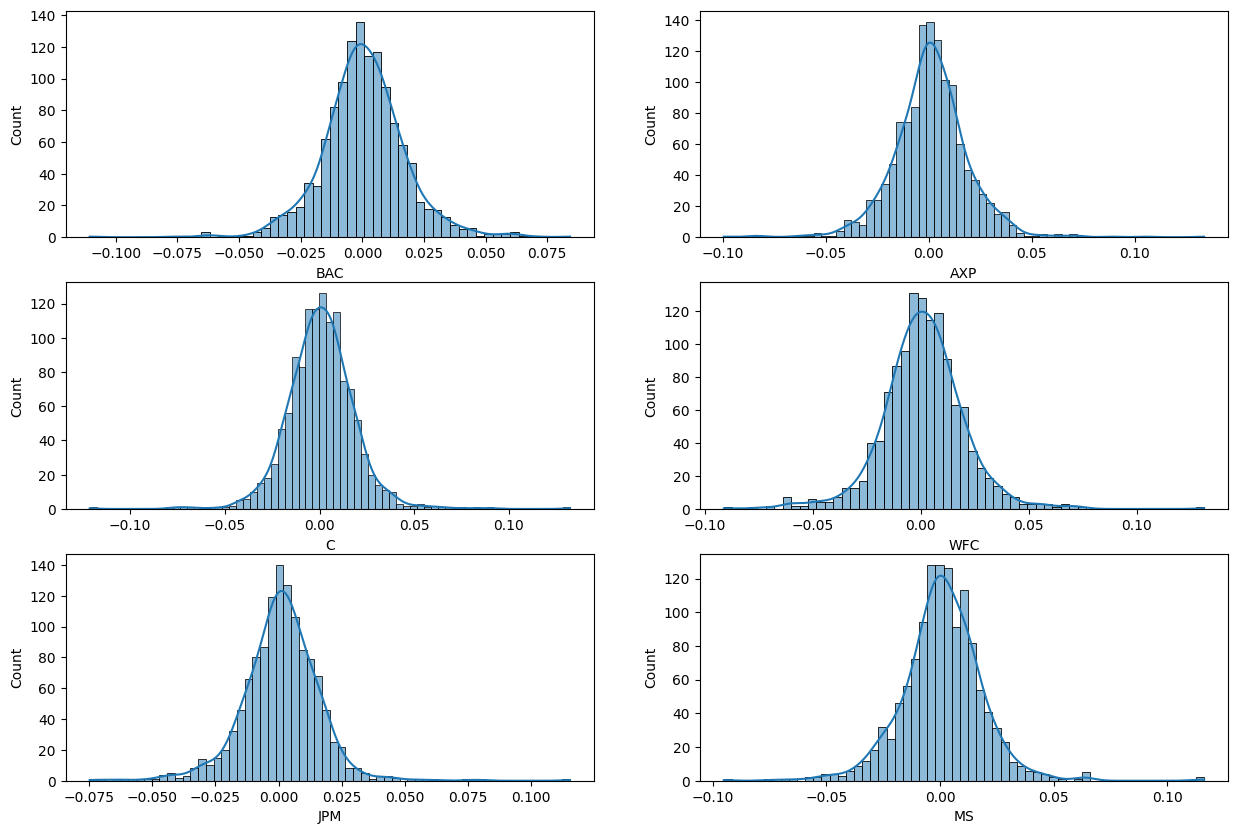

In [6]:
# now making a histogram out of this using seaborn
col_name=df_portfolio.columns
plt.figure(figsize=(15,10))
for i,name in enumerate(col_name):
  plt.subplot(3,2,i+1)
  sns.histplot(df_returns,x=name,kde=True)



In [7]:
# finding out the skewness of different tickers stock prices
for idx,name in enumerate(col_name):
 print(f"The skewness of {name} is equal to:")
 print(df_returns[name].skew())

# .skew is the function to find out the skewness of the histplot to find out how much of the portion of returns are on which side

The skewness of BAC is equal to:
-0.028613452424351152
The skewness of AXP is equal to:
0.21894170876343338
The skewness of C is equal to:
0.19519318175149544
The skewness of WFC is equal to:
0.07835166724163452
The skewness of JPM is equal to:
0.11456615818836786
The skewness of MS is equal to:
0.15785644697042012


In [8]:
# Lets analize kurtosis
from scipy.stats import kurtosis
for i,name in enumerate(col_name):
  print(f"The Kurtois value of {name} is equal to:")
  print(df_returns[name].kurtosis())
  # kurtosis value greater than 3 implies a leptokurtic behavour and a kurtosis value less than 3 represent a platykurtic behaviour
  # -ve skewness and a higher kurtosis value represent more risk as the high probabilty of extreme large neagtive outcomes

The Kurtois value of BAC is equal to:
3.2737831345056634
The Kurtois value of AXP is equal to:
5.246564794091934
The Kurtois value of C is equal to:
5.712317824711653
The Kurtois value of WFC is equal to:
3.5243482433731534
The Kurtois value of JPM is equal to:
5.182569955781179
The Kurtois value of MS is equal to:
4.196189236904735


Investors look for stocks with most positive skewness and least kurtosis value

 OBSERVATION MADE
  


> Add blockquote



In [9]:
# Stock price trends
# now lets observe the trend of closing prices of the tickers
# will try to make graphs of close prices of different tickers

In [10]:
def column_price_history(df_portfolio):
  figure,axis=plt.subplots(figsize=(10,6))
  # now i want the same thing for every ticker so better i should you a for loop
  for i,name in enumerate(df_portfolio):
   axis.plot(df_portfolio.index,df_portfolio[name],label=name)
  axis.set_title("Close Price History")
  axis.set_xlabel("Date")
  axis.set_ylabel("Close Price")
  plt.legend(loc="upper left",ncol=2,fontsize="small")
  plt.tight_layout
  plt.show()



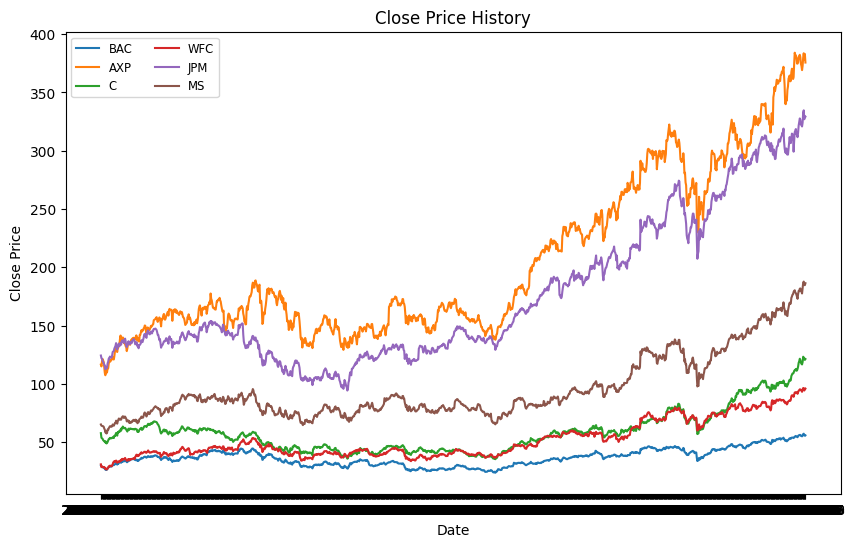

In [11]:
column_price_history(df_portfolio)

Cummulative Close Price Trends

In [12]:
# Looking at how 1 rupees grows over the selected time period as we fing the cummulative returns
df_cumreturns=(df_returns+1).cumprod()

In [13]:
import matplotlib.dates as mdates

In [14]:
def cummulative_returns(df_cumreturns):
  df_cumreturns.index = pd.to_datetime(df_cumreturns.index)  #-----
  figure,axis=plt.subplots(figsize=(10,6))
  # now i want the same thing for every ticker so better i should you a for loop
  for i,name in enumerate(df_cumreturns):
   axis.plot(df_cumreturns.index,df_cumreturns[name],label=name)
  #
  axis.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
  axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
  #
  axis.set_title("Cummulative returns")
  axis.set_xlabel("Date")
  axis.set_ylabel("Value of Rs.1 investment")
  plt.legend(loc="upper left",ncol=2,fontsize="small")
  plt.tight_layout()
  plt.show()


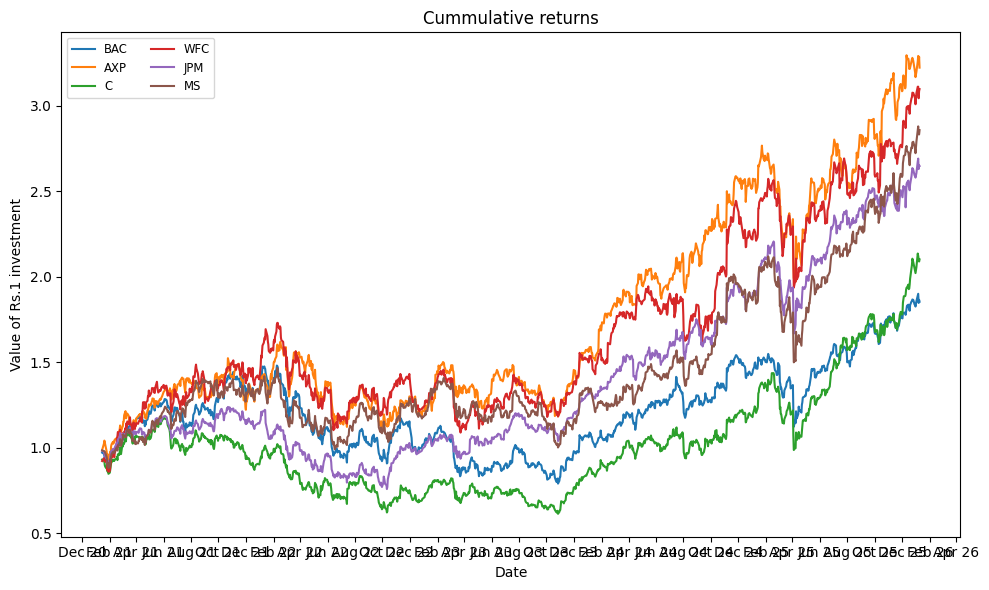

In [15]:
cummulative_returns(df_cumreturns)

CORRELATION MATRIX

In [16]:
# Heatmap of correlation matrix to analysize the stock correlation
def correlation_matrix(df_returns):
  sns.heatmap(df_returns.corr(),annot=True,cmap="Greens")
  plt.title("Correlation Matrix")

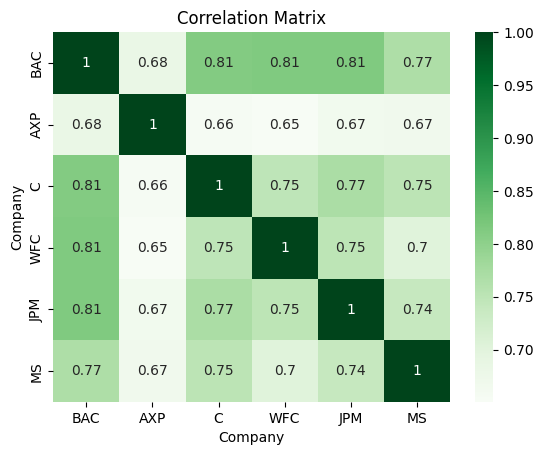

In [17]:
correlation_matrix(df_returns)

**Optimal Portfolio & Efficient Frontier**

In [18]:
# we will take a combination of 2000 weight distributions in the portfolio to find out the most optimum one
# Number of portfolio
num_portfolio=2000

# Number of assets in the portfolio
num_stocks=len(df_returns.columns)

# Risk Free Rate
risk_free_rate=0.0417/252  #assumed(will calculate this one as well)

def opt_portfolio(df_returns,num_portfolio,num_stocks,risk_free_rate):
  mean_returns=df_returns.mean()

  cov_matrix=df_returns.cov()

  # Making arrays to store data later to make a df
  all_returns=[]
  all_sharpe_ratios=[]
  all_weights=[]
  all_standard_dev=[]

  # Monte carlo simulation to take 6 random weights
  for i in range(num_portfolio):
    weights=np.random.random(num_stocks)
    weights=weights/weights.sum()

    # portfolio expected return--->
    av_port_ret=np.dot(weights,mean_returns)

    # portfolio variance--->
    port_var=np.dot(weights,np.dot(weights,cov_matrix))  #---# this tis the formula used in the modern portfolio theory for finding out the variance
    port_stand_dev=np.sqrt(port_var)  #ye to ek hi ayega na

    # Sharpe ratio--->
    sharpe=(av_port_ret-risk_free_rate)/port_stand_dev

    # Now putting all values into the array
    all_returns.append(av_port_ret)
    all_sharpe_ratios.append(sharpe)
    all_weights.append(weights)
    all_standard_dev.append(port_stand_dev) #volatility

# Now creating a dataframe outof this
  results=pd.DataFrame({"Return":all_returns,"Volatility":all_standard_dev,"Sharpe":all_sharpe_ratios})
  results["Weights"]=all_weights
  # print(results)

# Now we have got sharpe ratios volatilty weights Return fo portfolio
# Now we need to choose the maximum sharpe ratio and minimum risk
  max_sharpe_ratio=results.iloc[results["Sharpe"].idxmax()]
  print("For Maximum Sharpe Ratio:")
  print(max_sharpe_ratio)
# Now i need also theportfolio with minimum volatility
  min_volatility=results.iloc[results["Volatility"].idxmin()]
  print("For Minimum Volatility:")
  print(min_volatility)
  # print(max_sharpe_ratio["Weights"])
# Now we will make some plots Volatility(x) v/s Returns(y)
# -----scatter plot----
  plt.figure(figsize=(10,6))
  plt.scatter(results["Volatility"],results["Return"],cmap='plasma',marker="o",c=results["Sharpe"])
  plt.colorbar(label='Sharpe')
  plt.xlabel("Volatility")
  plt.ylabel("Return")
  plt.title("Efficient Frontier")
  # for maximum sharpe ratio plot volatiity vs return
  plt.scatter(max_sharpe_ratio["Volatility"],max_sharpe_ratio["Return"],marker="*",c="red",s=15)
  # for minimum volatility portfolio plot volatitlity and return
  plt.scatter(min_volatility["Volatility"],min_volatility["Return"],marker="*",c="black")
  plt.legend()


For Maximum Sharpe Ratio:
Return                                                 0.001026
Volatility                                             0.015591
Sharpe                                                 0.055202
Weights       [0.0009800085834290985, 0.4300568920115086, 0....
Name: 1698, dtype: object
For Minimum Volatility:
Return                                                 0.000912
Volatility                                             0.014911
Sharpe                                                 0.050031
Weights       [0.06236601537073029, 0.14270339368401236, 0.1...
Name: 1449, dtype: object


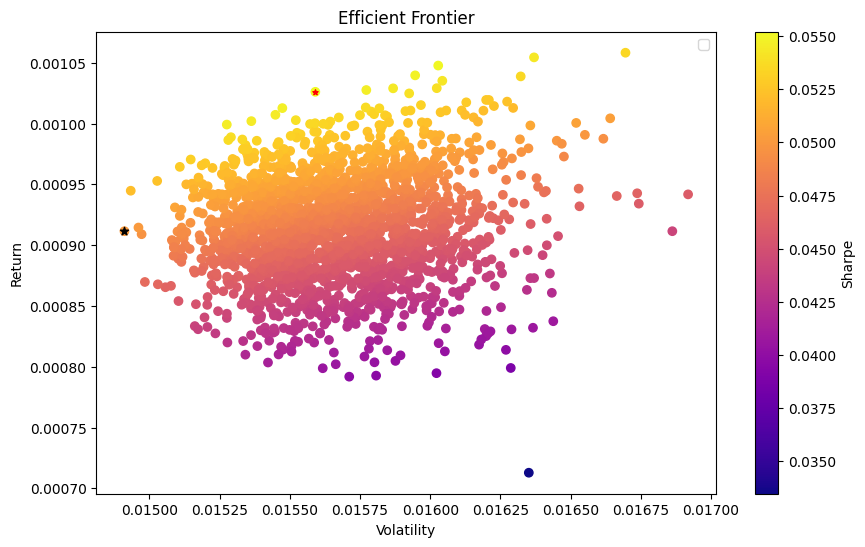

In [19]:
opt_portfolio(df_returns,num_portfolio,num_stocks,risk_free_rate)
# This is daily thing annualized by multiplying by 252

**CAPM Analysis**

In [20]:
def CAPM_model(df_returns):
  # risk free rate(US 10year treasury rate)
  risk_free_rate=0.0417

  num_stocks=len(df_returns.columns)
  # taking weights

  weights=np.random.random(num_stocks)
  weights=weights/weights.sum()

  # excess returns over the risk free rate
  excess_returns=df_returns-risk_free_rate/252
  portfolio_excess_returns=np.dot(excess_returns.values,weights)

  # Check if portfolio_excess_returns is 1D
  if portfolio_excess_returns.ndim > 1:
    portfolio_excess_returns = portfolio_excess_returns.flatten()

  # calculating market return
  # Instead of using the same end_date string:
  actual_end = (pd.to_datetime(end_date) + pd.Timedelta(days=1)).strftime('%Y-%m-%d') #---actually when we download the data from the yf.downlaod it skips the last date
  market_close_prices = yf.download("^GSPC", start=start_date, end=actual_end)["Close"]
  market_returns=market_close_prices.pct_change().dropna()
  market_excess_returns=market_returns-(risk_free_rate/252)
  # print(market_excess_returns)
  # Ensure both are 1D arrays
  if market_excess_returns.ndim > 1:
      market_excess_returns = np.array(market_excess_returns).flatten() #----pandas array has no attribute flatten() only numpy array has tha

  slope,intercept,rvalue,pvalue,stderr=linregress(market_excess_returns,portfolio_excess_returns)

  # Beta(this is the systematic risk)
  beta=slope

  # Expected Market Return and annual expected market return
  mean_market_excess_returns=market_excess_returns.mean()
  expected_market_return_annual=(mean_market_excess_returns*252)+risk_free_rate

  expected_portfolio_annual_returns=risk_free_rate + beta*(expected_market_return_annual-risk_free_rate) #CAPM Formula
  print("CAPM Analysis Results:")
  print(f"Beta(systematic risk):{beta}")
  print(f"Expected Market Return:{expected_market_return_annual}")
  print(f"Expected Portfolio Return(CAPM):{expected_portfolio_annual_returns}")

  # Now making plots of CAPM
  plt.figure(figsize=(6,4))
  plt.scatter(market_excess_returns,portfolio_excess_returns,alpha=0.7,s=15,label="stock")
  plt.plot(market_excess_returns,intercept+slope*market_excess_returns,"r",label="CAPM line")
  plt.xlabel("Risk Premium")
  plt.ylabel("Excess Return")
  plt.title("CAPM Analysis")
  plt.legend()



[*********************100%***********************]  1 of 1 completed


CAPM Analysis Results:
Beta(systematic risk):1.0539354901079434
Expected Market Return:0.1366067757100679
Expected Portfolio Return(CAPM):0.14172561917255508


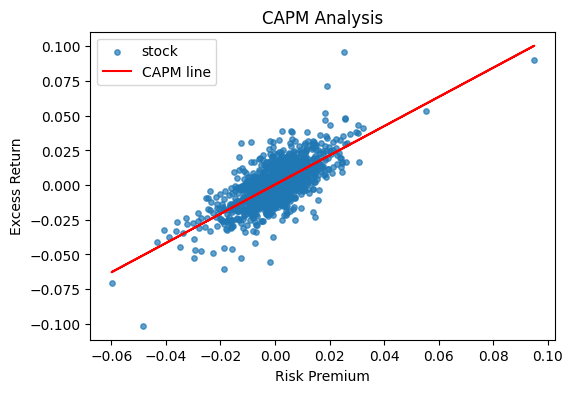

In [21]:
CAPM_model(df_returns)

**VaR & CVaR Calculation**

In [22]:
df_returns.mean()
# taken portfolio value to be 1
investment_value=1
weights=np.random.random(num_stocks)
weights=weights/weights.sum()
portfolio_mean_return=np.dot(df_returns.mean(),weights)
investment_mean_return=(portfolio_mean_return+1)*investment_value
cov_matrix=df_returns.cov()
portfolio_variance=np.dot(weights,np.dot(weights,cov_matrix))
portfolio_std=np.sqrt(portfolio_variance)
investment_std=portfolio_std*investment_value
confidence=0.05  #taken


Text(0.5, 0, 'Investment_Returns')

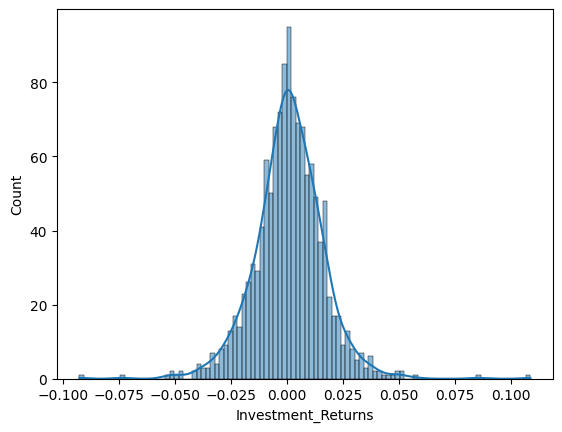

In [23]:
sns.histplot(np.dot(df_returns,weights),bins=100,kde=True)
plt.xlabel("Investment_Returns")

In [34]:
from scipy.stats import norm
percent_point=norm.ppf(confidence,investment_mean_return,investment_std)
value_at_risk=investment_value-percent_point
print(value_at_risk)



0.024607314740634822


In [25]:
# for each day the risk cummulates and to account for the ups and downs in gains and losses we generally take the daily factor as squareroot
value_at_risks=value_at_risk*np.sqrt(range(1,31))  #on a monthly basis

Text(0, 0.5, 'Maximum Loss')

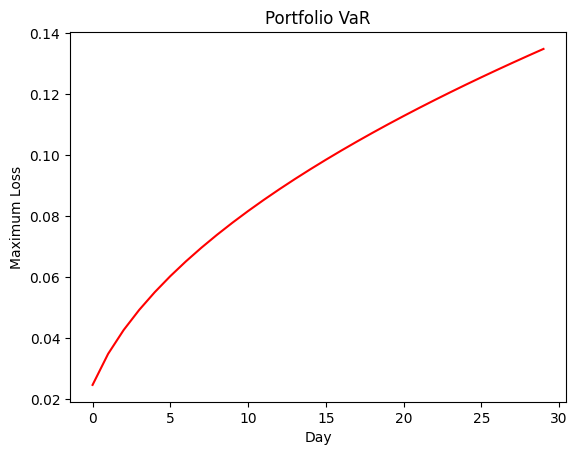

In [26]:
plt.plot(value_at_risks,"r")
plt.title("Portfolio VaR")
plt.xlabel("Day")
plt.ylabel("Maximum Loss")


In [27]:
investment_returns=np.dot(df_returns,weights)*investment_value

In [28]:
investment_returns
new=[]
for i in investment_returns:
  if i<(-value_at_risk):
    new.append(i)

In [29]:
less_returns=np.array(new)
Expected_shortfall=less_returns.mean()

In [41]:
Expected_shortfall

np.float64(-0.03447184760382775)

In [31]:
from scipy.stats import norm

def cvar(investment_mean_return,investment_std, confidence=0.95):

    alpha = 1 - confidence

    # 1. Find the Z-score for the cutoff point
    z_score = norm.ppf(alpha)
    print(z_score)

    # 2. Calculate the PDF (Probability Density Function) at that z-score
    pdf_at_z = norm.pdf(z_score)
    print(pdf_at_z)
    # 3. Parametric CVaR Formula
    # It calculates the average of the tail relative to the normal distribution
    cvar = investment_mean_return - investment_std* (pdf_at_z / alpha)

    return cvar


In [40]:
cvar(investment_mean_return,investment_std, confidence=0.95)  #expected tail loss

-1.6448536269514722
0.10313564037537139


np.float64(0.9689128030520091)

In [33]:
1-value_at_risk

np.float64(0.9753926852593652)

**Results & Calculation**



*   Simulated 2000 random portfolios to explore different risk–return combinations.
*   Identified the maximum Sharpe ratio portfolio and the minimum volatility portfolio from the simulation.


**Maximum Sharpe Ratio Portfolio**


*   Sharpe Ratio:**0.8763**
*   Return:**22.98%**
*   Volatility:**23.67%**

*   Recorded returns, volatility, Sharpe ratio, and asset weights for both optimal portfolios.


**CAPM Analysis**


*   Expected market return:**13.66%**

*   Portfolio Beta:**1.054**

*   Expected portfolio return using CAPM :**14.17%**

*   Compared CAPM-based expected return with portfolio optimization results.


**Downside Risk**


*   Value at Risk (VaR):**-2.46%**
*   Conditional Value at Risk (CVaR):**-3.45%**


**Distribution Analysis**

*   Skewness used to measure asymmetry of returns

*   Kurtosis to measure tail heaviness

*   Combined results give insight into both expected performance and tail risk behavior.













